## **Introduction**

In this project, we fine-tuned an open-source language model to predict product prices using the QLoRA approach. QLoRA enables efficient fine-tuning with reduced memory usage and fewer hyperparameters. The entire process was executed locally on a personal computer.


In [1]:
# !pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece

In [2]:
import os
import re
import math
from tqdm import tqdm
from huggingface_hub import login
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from torch import float16
from peft import LoraConfig, PeftModel
from datetime import datetime
from dotenv import load_dotenv
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() and torch.cuda.device_count() > 0 else "No CUDA device available")

True
1
Quadro RTX 4000


In [4]:
# Samples
usedata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)
usedata.to_pandas().head(2)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Industrial & Scientific,"ROVSUN Ice Maker Machine Countertop, Make 44lb...",3.7,61,[【Quick Ice Making】This countertop ice machine...,[],None,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Our Point of View on the Euhomy Ic...,ROVSUN,"[Appliances, Refrigerators, Freezers & Ice Mak...","{""Brand"": ""ROVSUN"", ""Model Name"": ""ICM-2005"", ...",B08Z743RRD,None,None,None
1,Tools & Home Improvement,"HANSGO Egg Holder for Refrigerator, Deviled Eg...",4.2,75,"[Plastic, Practical Kitchen Storage - Our egg ...",[],None,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['10 Eggs Egg Holder for Refrigerato...,HANSGO,"[Appliances, Parts & Accessories, Refrigerator...","{""Manufacturer"": ""HANSGO"", ""Part Number"": ""HAN...",B097BQDGHJ,None,None,None


In [5]:
## Env
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
# Model
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"           # Lightweight open-source chat model
FINETUNED_MODEL = f"ed-donner/pricer-2024-09-13_13.04.39"

In [7]:
from peft import PeftConfig
config = PeftConfig.from_pretrained("ed-donner/pricer-2024-09-13_13.04.39")
print(config.base_model_name_or_path)

meta-llama/Meta-Llama-3.1-8B


In [ ]:
# Load the base model in 8-bit precision using the defined quantization configuration.

quant_config = BitsAndBytesConfig(load_in_8bit=True)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    quantization_config=quant_config,
    device_map="auto",
)

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Memory footprint: 1.2 GB


In [9]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear8bitLt(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear8bitLt(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear8bitLt(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear8bitLt(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSN

In [ ]:
# Load the base model in 4-bit precision using the defined quantization configuration.

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4")

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,            ##
    quantization_config=quant_config,
    device_map="auto",
)
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:,.2f} GB")

Memory footprint: 0.75 GB


In [11]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), e

In [12]:
# Hyperparameters for QLoRA Fine-Tuning
LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]

lora_q_proj = 4096 * 32 + 4096 * 32      # Number of weights
lora_k_proj = 4096 * 32 + 1024 * 32
lora_v_proj = 4096 * 32 + 1024 * 32
lora_o_proj = 4096 * 32 + 4096 * 32

lora_layer = lora_q_proj + lora_k_proj + lora_v_proj + lora_o_proj  # Each layer 
params = lora_layer * 32

size = (params * 4) / 1_000_000            # Total size
print(f"Total number of params: {params:,} and size {size:,.1f}MB")

Total number of params: 27,262,976 and size 109.1MB


In [13]:
# BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
HF_USER = "ed-donner"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

## color for output
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [14]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [15]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']
test[5]

{'text': 'How much does this cost to the nearest dollar?\n\nHorror Bookmarks, Resin Horror Bookmarks for Adults, The Best Gift for Fans of Horror Novels, Horror Personalized Bookmarks for Men Women, Horror Figures Sculpture Bookmarks (Set)\nHorror Bookmarks - The Best Gift for Fans of Horror Novels, Resin Horror Bookmarks for Adults, Half-Length Figure Sculpture Bookmarks, Horror Bookmark Set for Men Women Office Supplies Specification Upper Part Material Resin Lower Part Of Material Wood Character Size 3.3cm x 2cm / x Overall Size 10cm / 4inch Package Includes 1 / 6 x Horror bookmarks - the best gift for fans of horror novels Note 1. Due to manual measurements, please allow slight measurement deviations. 2. Due to the different display and lighting effects, the\n\nPrice is $',
 'price': 31.99}

In [ ]:
## Choose the right quantization (4 bits or 8 bits)

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [17]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

# Define base model path
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load the model with quantization and device map
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,   
    quantization_config=quant_config,
    device_map="auto",
)

# Set pad_token_id for generation
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Print GPU memory usage
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Memory footprint: 0.7 GB


In [18]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

extract_price("Price is $999 blah blah so cheap")

999.0

In [19]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

model_predict(test[1]['text'])

10.0

1: Guess: $199.00 Truth: $374.41 Error: $175.41 SLE: 0.40 Item: OEM AC Compressor w/...
2: Guess: $10.00 Truth: $225.11 Error: $215.11 SLE: 9.14 Item: Motorcraft YB3125 Fa...
3: Guess: $10.90 Truth: $61.68 Error: $50.78 SLE: 2.76 Item: Dorman Front Washer ...
4: Guess: $199.00 Truth: $599.99 Error: $400.99 SLE: 1.21 Item: HP Premium HD Plus T...
5: Guess: $19.90 Truth: $16.99 Error: $2.91 SLE: 0.02 Item: Super Switch Pickup ...
6: Guess: $10.00 Truth: $31.99 Error: $21.99 SLE: 1.21 Item: Horror Bookmarks, Re...
7: Guess: $199.00 Truth: $101.79 Error: $97.21 SLE: 0.44 Item: SK6241 - Stinger 4 G...
8: Guess: $129.00 Truth: $289.00 Error: $160.00 SLE: 0.64 Item: Godox ML60Bi LED Lig...
9: Guess: $129.00 Truth: $635.86 Error: $506.86 SLE: 2.52 Item: Randall G3 Plus Comb...
10: Guess: $129.00 Truth: $65.99 Error: $63.01 SLE: 0.44 Item: HOLDWILL 6 Pack LED ...
11: Guess: $129.00 Truth: $254.21 Error: $125.21 SLE: 0.46 Item: Viking Horns 3 Gallo...
12: Guess: $100.00 Truth: $412.99 Error: $31

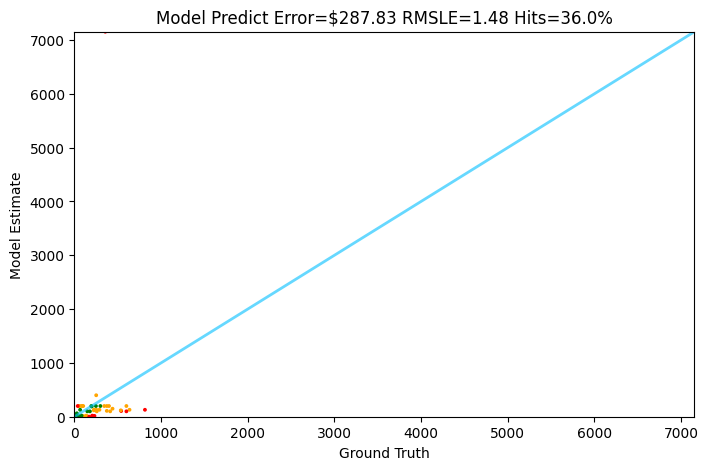

In [22]:
# E Evaluation

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<80 or error/truth < 0.4:
            return "green"
        elif error<150 or error/truth < 0.8:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(8, 5))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()


Tester(predictor=model_predict, data=test, size=50).run()

## Summary

1. **Data Limitations & Lightweight Base Model**  
   Due to the large dataset size and high computational demands, we utilized a limited data sample and a lightweight open-source model for this analysis, executed on a local machine.

2. **Fine-Tuning Results**  
   The QLoRA fine-tuning approach achieved modest improvements while reducing memory usage and minimizing the need for extensive hyperparameter tuning. However, further optimization with a larger dataset and more powerful LLMs is recommended to improve performance.

3. **Acknowledgment & Purpose**  
   We gratefully acknowledge Ed Donner for his guidance on this exercise. This project was conducted solely for educational and practice purposes.